# Bibliotecas

In [12]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import utils

# Cargar los datos

Para cargar los datos del conjunto BETA, podemos utilizar las funciones load_ssvep_data y load_additional_info, definidas en el archivo utils. Estas funciones nos permiten cargar los registros EEG de un sujeto específico, así como la información complementaria incluida en el conjunto de datos, como las frecuencias de los estímulos, los índices de los electrodos, etc.

También utilizamos la función select_occipital_electrodes, incluida igualmente en el archivo utils, para obtener los índices y nombres correspondientes a todos los electrodos de la región occipital.

In [13]:
# Importación y configuración inicial de datos para el sujeto 18
registro_eeg, registro_eeg_estimulo, duracion_ensayo = utils.load_ssvep_data("Database BETA", 18)

# Frecuencia de adquisición de datos
frecuencia_muestreo = 250

# Carga de información auxiliar (común para todos los participantes)
frecuencias_estimulacion, nombres_electrodos = utils.load_ssvep_additional_info("Database BETA/S1.mat")

# Filtrado de electrodos occipitales: lista de tuplas [nombre, índice], lista de índices y lista de nombres
electrodos_occipitales, indices_occipitales, nombres_occipitales = utils.select_occipital_electrodes(nombres_electrodos)

# Determinación de muestras sin estímulo (0,5 segundos antes y después del estímulo)
muestras_sin_estimulo = int(0.5 * frecuencia_muestreo)

# Definición de vectores temporales para el ensayo completo y para la parte con estímulo
tiempo_estimulo = np.arange(0, len(registro_eeg_estimulo[0]) / frecuencia_muestreo, 1 / frecuencia_muestreo)
tiempo_completo = np.arange(0, len(registro_eeg[0]) / frecuencia_muestreo, 1 / frecuencia_muestreo)

# Cantidad de electrodos utilizados
cantidad_electrodos = len(registro_eeg)

#### Función `load_ssvep_data`

Esta función permite cargar los datos EEG de un sujeto específico del conjunto **BETA**. Su objetivo es facilitar el acceso a las señales registradas, tanto en su forma original como en una versión en la que se eliminan los periodos sin estímulo (reposo).

##### ¿Qué hace la función?

1. **Construye el nombre del archivo** correspondiente al sujeto, concatenando la ruta y el identificador del sujeto (`S{n}.mat`), por ejemplo: `S18.mat`.

2. **Establece la duración del ensayo** (`duracion_ensayo`) según el número del sujeto:
   - Si el número del sujeto es mayor que 15 (es decir, S16–S70), la duración es de **4 segundos**.
   - En caso contrario (S1–S15), la duración es de **3 segundos**.

3. **Carga el archivo `.mat`** utilizando `scipy.io.loadmat`, que contiene una estructura con los datos EEG.

4. **Extrae los datos EEG** desde la estructura interna del archivo:
   \[
   \text{canal} \times \text{tiempo} \times \text{ensayo} \times \text{frecuencia}
   \]

5. **Elimina los periodos sin estímulo** al principio y al final del ensayo:
   - Se eliminan **0,5 segundos** al inicio y al final.
   - Con una frecuencia de muestreo de **250 Hz**, esto equivale a `0.5 × 250 = 125` muestras antes y después.
   - Como resultado, se obtienen **500 muestras** centradas únicamente en el periodo de estimulación.

6. **Devuelve una tupla con tres elementos**:
   - `registros_eeg`: datos EEG originales (con los periodos de reposo).
   - `registros_estimulo_solo`: datos EEG con solo la parte útil del estímulo.
   - `duracion_ensayo`: duración del ensayo (3 o 4 segundos).

Esta función es útil para preparar los datos antes de aplicar cualquier método de análisis o clasificación en el contexto de interfaces cerebro-computadora (BCI) basadas en SSVEP.

#### Función `load_ssvep_additional_info`

Esta función permite acceder a información complementaria contenida en los archivos del conjunto de datos **BETA**. Dicha información es útil para interpretar las señales EEG y está asociada a cada condición experimental y disposición de electrodos.

##### ¿Qué hace esta función?

1. **Carga el archivo `.mat`** especificado en la ruta de entrada, utilizando la función `scipy.io.loadmat`.

2. **Extrae las frecuencias** de estimulación utilizadas en los ensayos:
   - Hay **40 frecuencias distintas**, que se encuentran dentro del campo `suppl_info['freqs']`.

3. **Obtiene los nombres de los 64 canales EEG** usados en la adquisición:
   - Los nombres están en la cuarta columna (índice 3) del arreglo de canales, que se encuentra en `suppl_info['chan']`.

##### ¿Qué devuelve?

La función retorna una tupla con dos elementos:

- Una lista de **frecuencias** (en Hz) correspondientes a cada índice de frecuencia del conjunto.
- Una lista con los **nombres de los canales EEG** (por ejemplo, "Oz", "O1", "Pz", etc.).

Esta función es clave para vincular los datos con sus correspondientes condiciones experimentales y para seleccionar regiones específicas del cuero cabelludo, como el área occipital.

#### Función `select_occipital_electrodes`

Esta función permite identificar los electrodos ubicados en la región **occipital** del cuero cabelludo, basándose en la convención internacional de nombres para canales EEG.

##### ¿Qué hace esta función?

1. Recorre la lista de nombres de canales EEG proporcionada como argumento.
2. Selecciona aquellos nombres que **contienen la letra "O"**, ya que esta letra se usa comúnmente para designar electrodos occipitales (por ejemplo, "O1", "Oz", "PO3", etc.).
3. Guarda la información de los electrodos seleccionados de tres formas distintas:
   - Una lista de pares \([índice, nombre]\),
   - Una lista con los **índices**,
   - Una lista con los **nombres**.

##### ¿Qué devuelve?

La función retorna una tupla con tres elementos:

- Una lista de listas con el **índice y nombre** de cada electrodo occipital.
- Una lista de **índices**.
- Una lista de **nombres**.

Esta selección es especialmente útil para centrar el análisis en las regiones cerebrales responsables de procesar estímulos visuales, donde se generan las señales SSVEP.

# Visualización de datos

Primero representamos un ensayo promedio y marcamos los puntos de inicio y fin del parpadeo del estímulo (0,5 segundos y 3,5 segundos).


Text(0, 0.5, 'Amplitud')

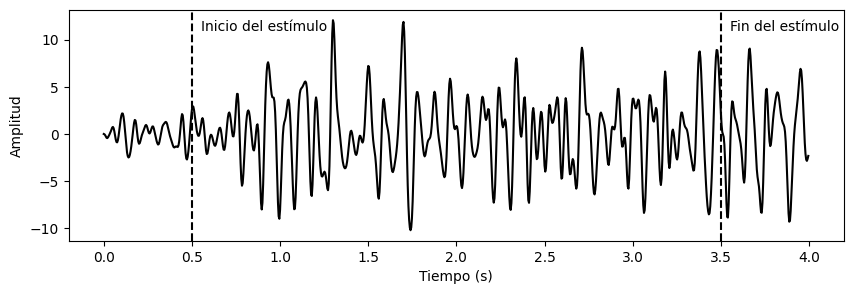

In [14]:
# Extracción y procesamiento del ensayo 2 bajo estimulación de 10,6 Hz
# Se toma el ensayo con índice 2 y la frecuencia con índice 10
# Se promedian las señales registradas en los electrodos occipitales
senal_promediada = np.mean(registro_eeg[indices_occipitales, :, 2, 10], axis=0)

# Parámetros del filtro: frecuencias de corte inferior y superior
frecuencia_min = 5
frecuencia_max = 25
frecuencia_muestreo = 250  # Hz

# Diseño de un filtro Butterworth de orden 4 para el rango 5–25 Hz
coef_b, coef_a = signal.butter(4, [frecuencia_min, frecuencia_max], fs=frecuencia_muestreo, btype='band')

# Aplicación del filtro a la señal promediada
senal_filtrada = signal.lfilter(coef_b, coef_a, senal_promediada)

# Visualización de la señal filtrada
plt.figure(figsize=(10, 3))
plt.plot(tiempo_completo, senal_filtrada, color="black")

# Indicadores de inicio y fin del estímulo visual
plt.axvline(x=0.5, color="black", linestyle="dashed")
plt.text(0.55, 11, "Inicio del estímulo")
plt.axvline(x=3.5, color="black", linestyle="dashed")
plt.text(3.55, 11, "Fin del estímulo")

plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

#### Promedio de un ensayo bajo el estímulo de 10,6 Hz

En este fragmento de código se realiza un análisis sobre los datos EEG correspondientes a un estímulo visual de **10,6 Hz**.

##### ¿Cómo sabemos que es 10,6 Hz?

Los estímulos SSVEP en el conjunto de datos BETA están organizados por frecuencia, y cada frecuencia tiene asignado un **índice**. 
La variable `frecuencias_estimulacion` contiene una lista de todas las frecuencias utilizadas, y accediendo a su posición 10 obtenemos:

```python
frecuencias_estimulacion[10]  # Devuelve 10.6
```

**Representación de senal_promediada = np.mean(registro_eeg[indices_occipitales, :, 2, 10], axis=0)**

Esto hace lo siguiente:

- Se extraen los datos EEG de todos los electrodos occipitales (occipital_electrodes_indexes).

- Se selecciona el ensayo número 2 (índice 2).

- Se elige la condición de estímulo asociada a la frecuencia de 10,6 Hz (índice 10).

- Luego se calcula el promedio entre todos los electrodos seleccionados, resultando en una única señal representativa.


**¿Qué utilidad tiene este promedio?**

Obtener una señal promedio permite representar la evolución temporal de la actividad cerebral ante un estímulo concreto, suavizando el ruido individual de cada electrodo y resaltando mejor el patrón de respuesta evocado por la frecuencia específica del estímulo.




#### Filtro de Butterworth de 4.º orden con paso de banda entre 5 y 25 Hz

En este fragmento de código se diseña un **filtro paso banda** utilizando la función `butter` de la librería `scipy.signal`. El objetivo del filtro es **eliminar componentes de baja y alta frecuencia** de la señal EEG, conservando únicamente aquellas oscilaciones que se encuentran en el rango entre **5 Hz y 25 Hz**, que son típicas en estudios de SSVEP y otras señales cerebrales de interés.

```python
frecuencia_min = 5
frecuencia_max = 25
frecuencia_muestreo = 250  
coef_b, coef_a = signal.butter(4, [frecuencia_min, frecuencia_max], fs=frecuencia_muestreo, btype='band')
```

**¿Qué hace cada línea?**
- frecuencia_min y frecuencia_max: establecen los límites del filtro paso banda.

- frecuencia_muestreo: frecuencia de muestreo de la señal, que permite normalizar las frecuencias del filtro.

- signal.butter(...): diseña un filtro de Butterworth de 4.º orden. Este tipo de filtro es suave y no presenta ondulaciones en su banda pasante (lo que lo hace ideal para señales fisiológicas).


El resultado son dos conjuntos de coeficientes:

- b: coeficientes del numerador del filtro (parte de salida).

- a: coeficientes del denominador (parte de retroalimentación).

Estos coeficientes se usan posteriormente con signal.lfilter(coef_b, coef_a, senal_promediada) para aplicar el filtrado a la señal.

**¿Por qué usar un filtro paso banda?**
En señales EEG es común filtrar las frecuencias fuera del rango de interés para:

- Eliminar ruido de baja frecuencia (por ejemplo, movimientos lentos o artefactos).

- Suprimir componentes de alta frecuencia que no contienen información relevante para el análisis (por ejemplo, ruido muscular).



```python
senal_filtrada = signal.lfilter(coef_b, coef_a, senal_promediada)
```
Esta operación devuelve la versión filtrada de la señal original. El resultado es una señal más limpia, centrada únicamente en el rango de frecuencias de interés (5–25 Hz), que puede analizarse o representarse posteriormente con más claridad.

**¿Por qué este rango de frecuencias?**
Este rango se elige porque las frecuencias de los estímulos SSVEP en el conjunto BETA se encuentran dentro del intervalo aproximado [6 Hz, 15 Hz], y se desea eliminar tanto el ruido de baja frecuencia (movimientos, respiración) como el de alta frecuencia (actividad muscular o interferencia eléctrica), mejorando así la relación señal-ruido.


A continuación, tomamos los datos de los electrodos **Oz** y **POz** y calculamos su diferencia durante el primer ensayo con un estímulo de **11 Hz**. Luego, representamos la señal resultante con y sin filtrado en banda. 

Además, calculamos el espectro de potencia mediante la **Transformada Rápida de Fourier (FFT)** y lo representamos para ambas versiones de la señal. 

Esto nos permite probar tanto la **selección de electrodos** como las funciones de **filtrado** y de **FFT**.

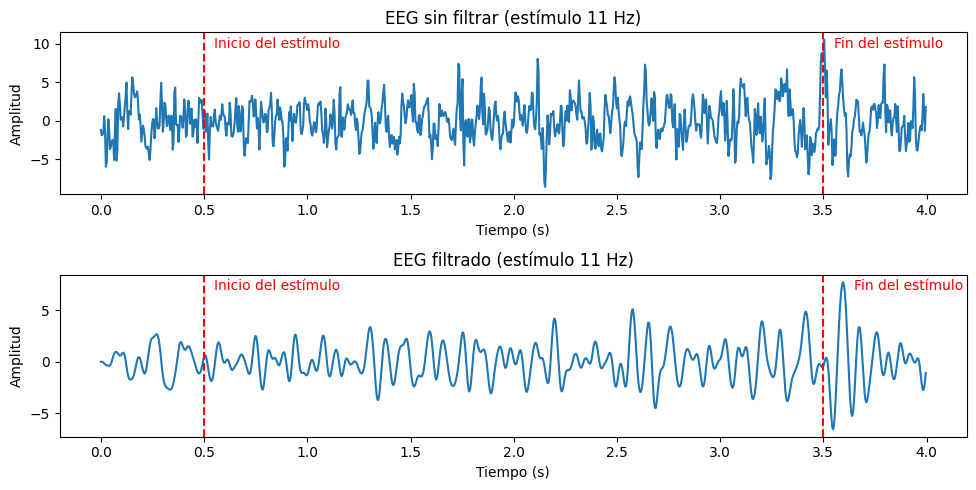

Frecuencia pico (sin filtrar): 11.0 Hz
Frecuencia pico (filtrada): 11.0 Hz


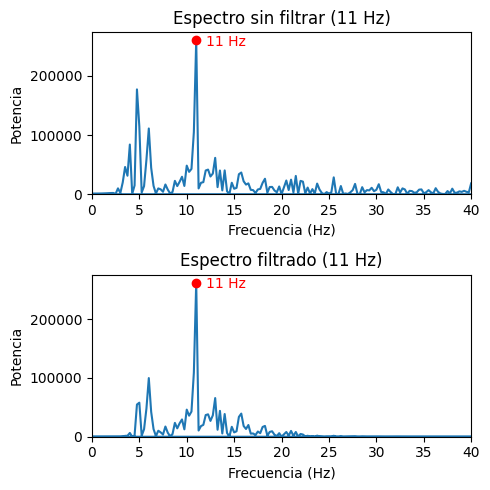

In [19]:
# Comparativa entre canales Oz (61) y POz (55) en el primer ensayo con estímulo de 11 Hz (índice 12)
senal_diferencial = registro_eeg[61, :, 0, 12] - registro_eeg[55, :, 0, 12]

# Parámetros del filtro paso banda
f_min = 5
f_max = 20
fs = 250  # Frecuencia de muestreo en Hz

# Filtro Butterworth de orden 4 en el rango de 5 a 20 Hz
filtro_b, filtro_a = signal.butter(4, [f_min, f_max], fs=fs, btype='band')

# Aplicación del filtro a la señal diferencial
senal_filtrada = signal.lfilter(filtro_b, filtro_a, senal_diferencial)

# Visualización de señales: original y filtrada
figura, ejes = plt.subplots(2, 1, figsize=(10, 5))

# Señal sin filtrar
ejes[0].plot(tiempo_completo, senal_diferencial)
ejes[0].set_title("EEG sin filtrar (estímulo 11 Hz)")
ejes[0].axvline(x=0.5, linestyle="dashed", color="red")
ejes[0].text(0.55, 9.5, "Inicio del estímulo", color="red")
ejes[0].axvline(x=3.5, linestyle="dashed", color="red")
ejes[0].text(3.55, 9.5, "Fin del estímulo", color="red")
ejes[0].set_xlabel("Tiempo (s)")
ejes[0].set_ylabel("Amplitud")

# Señal filtrada
ejes[1].plot(tiempo_completo, senal_filtrada)
ejes[1].set_title("EEG filtrado (estímulo 11 Hz)")
ejes[1].axvline(x=0.5, linestyle="dashed", color="red")
ejes[1].text(0.55, 7, "Inicio del estímulo", color="red")
ejes[1].axvline(x=3.5, linestyle="dashed", color="red")
ejes[1].text(3.65, 7, "Fin del estímulo", color="red")
ejes[1].set_xlabel("Tiempo (s)")
ejes[1].set_ylabel("Amplitud")

plt.tight_layout()
plt.show()

# Análisis del espectro de potencia (señal sin filtrar)
figura, graficas = plt.subplots(2, 1, figsize=(5, 5))

fft_cruda = np.fft.fft(senal_diferencial)
frecuencias = np.fft.fftfreq(len(senal_diferencial), d=1/fs)
potencia_cruda = np.abs(fft_cruda) ** 2

# Pico de frecuancia en la señal sin filtrar
print("Frecuencia pico (sin filtrar):", frecuencias[np.argmax(potencia_cruda)], "Hz")

# Representación del espectro sin filtrar
graficas[0].plot(frecuencias, potencia_cruda)
graficas[0].set_title("Espectro sin filtrar (11 Hz)")
graficas[0].set_xlabel("Frecuencia (Hz)")
graficas[0].set_ylabel("Potencia")
graficas[0].plot(frecuencias[np.argmax(potencia_cruda)], max(potencia_cruda[0:500]), "o", color="red")
graficas[0].text(frecuencias[np.argmax(potencia_cruda)] + 1, max(potencia_cruda[0:500]) - 10000, "11 Hz", color="red")
graficas[0].set_xlim(0, 40)
graficas[0].set_ylim(0)

# Análisis del espectro de potencia (señal filtrada)
fft_filtrada = np.fft.fft(senal_filtrada)
potencia_filtrada = np.abs(fft_filtrada) ** 2

print("Frecuencia pico (filtrada):", frecuencias[np.argmax(potencia_filtrada)], "Hz")

# Representación del espectro filtrado
graficas[1].plot(frecuencias, potencia_filtrada)
graficas[1].set_title("Espectro filtrado (11 Hz)")
graficas[1].set_xlabel("Frecuencia (Hz)")
graficas[1].set_ylabel("Potencia")
graficas[1].plot(frecuencias[np.argmax(potencia_filtrada)], max(potencia_filtrada[0:500]), "o", color="red")
graficas[1].text(frecuencias[np.argmax(potencia_filtrada)] + 1, max(potencia_filtrada[0:500]) - 10000, "11 Hz", color="red")
graficas[1].set_xlim(0, 40)
graficas[1].set_ylim(0)

plt.tight_layout()
plt.show()


#### Análisis espectral mediante FFT

Hemos realizado el análisis del contenido frecuencial de la señal EEG utilizando la **Transformada Rápida de Fourier (FFT)**. Esta transformación permite descomponer la señal en sus componentes de frecuencia y analizar cuánta energía (potencia) está presente en cada una.

```python
# Calculamos la FFT de la señal sin filtrar
fft_cruda = np.fft.fft(senal_diferencial)
frecuencias = np.fft.fftfreq(len(senal_diferencial), d=1/fs)
potencia_cruda = np.abs(fft_cruda) ** 2
```

**Explicación de cada línea:**
- np.fft.fft(senal_diferencial): calcula la FFT de la señal temporal senal_diferencial. El resultado (fft_cruda) es un conjunto de números complejos que representan la amplitud y fase de cada frecuencia.

- np.fft.fftfreq(len(senal_diferencial), d=1/fs): genera el vector de frecuencias asociadas a los componentes del resultado de la FFT.

    - len(senal_diferencial) es el número de muestras.

    - d=1/fs indica el intervalo temporal entre muestras (en segundos).

- np.abs(fft_cruda) ** 2: calcula el espectro de potencia, es decir, la energía contenida en cada componente de frecuencia. Al elevar el módulo de los coeficientes complejos al cuadrado, se obtiene una medida proporcional a la potencia de cada frecuencia.


##### Detección del pico principal en el espectro de potencia
Después de obtener el espectro de potencia, se identifica la frecuencia con mayor energía, que debería coincidir con la frecuencia del estímulo si la señal EEG ha captado adecuadamente la respuesta SSVEP:

```python
# Pico de frecuencia en la señal sin filtrar
print("Frecuencia pico (sin filtrar):", frecuencias[np.argmax(potencia_cruda)], "Hz")
```

- np.argmax(potencia_cruda): devuelve el índice del valor máximo del espectro de potencia.

- El resultado se imprime para confirmar visualmente que se detecta un pico en la frecuencia esperada (en este caso, 11 Hz si el estímulo fue a esa frecuencia).




Encontramos este ejemplo interesante al restar la señal del electrodo **POz** de la del electrodo **Oz**, por lo que lo hemos calculado aquí.


Text(0, 0.5, 'Amplitud')

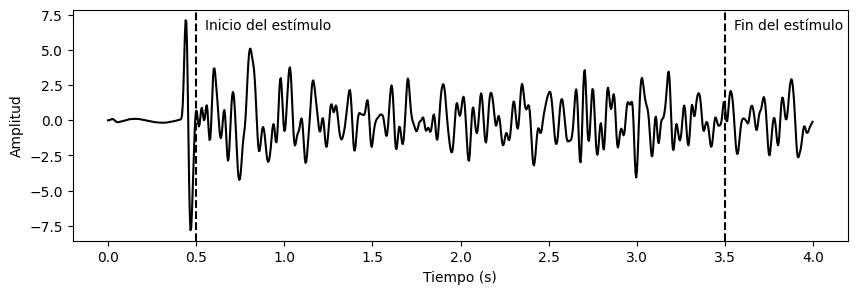

In [20]:
# Comparación entre los canales Oz (61) y POz (55) en el segundo ensayo (estímulo de 10,6 Hz, índice 10)
diferencia_eeg = registro_eeg[61, :, 2, 10] - registro_eeg[55, :, 2, 10]

# Configuración de frecuencias para el filtrado
frecuencia_baja = 5
frecuencia_alta = 25
fs = 250  # Frecuencia de muestreo en Hz

# Diseño del filtro Butterworth de 4.º orden
coeficientes_b, coeficientes_a = signal.butter(4, [frecuencia_baja, frecuencia_alta], fs=fs, btype='band')

# Aplicación del filtro a la señal (Oz - POz)
senal_filtrada = signal.lfilter(coeficientes_b, coeficientes_a, diferencia_eeg)

# Representación de la señal filtrada
plt.figure(figsize=(10, 3))
plt.plot(tiempo_completo, senal_filtrada, color="black")

# Marcadores de inicio y fin del estímulo
plt.axvline(x=0.5, linestyle="dashed", color="black")
plt.text(0.55, 6.5, "Inicio del estímulo")
plt.axvline(x=3.5, linestyle="dashed", color="black")
plt.text(3.55, 6.5, "Fin del estímulo")

plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")



Otra forma de marcar los periodos sin estímulo es **coloreando las zonas correspondientes**. En este caso, utilizamos el color rojo para resaltar esas áreas.


(0.0, 4.0)

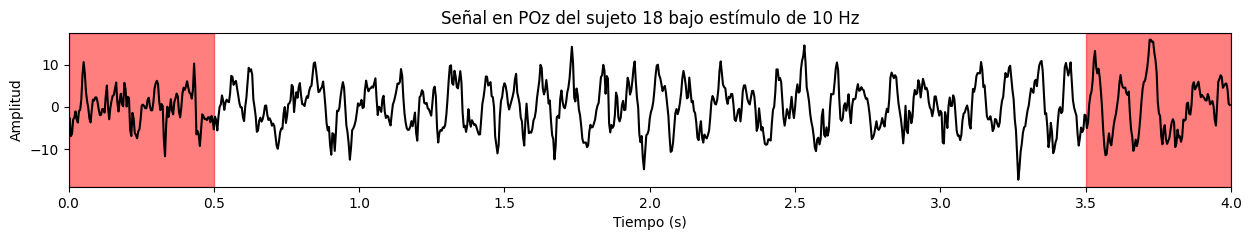

In [21]:
# Representación de un canal EEG específico en una figura alargada
plt.figure(figsize=(15, 2))

# Trazado de la señal del canal POz (índice 55), primer ensayo (0), frecuencia de estímulo índice 7 (10 Hz)
plt.plot(tiempo_completo, registro_eeg[55, :, 0, 7], color='black')

# Título explicativo del gráfico
plt.title("Señal en POz del sujeto 18 bajo estímulo de 10 Hz")

# Etiquetas de los ejes coordenados
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

# Sombreado del periodo previo al estímulo (0 a 0,5 s) en rojo translúcido
plt.axvspan(0, 0.5, color='red', alpha=0.5)

# Sombreado del periodo posterior al estímulo (3,5 a 4 s)
plt.axvspan(3.5, 4.0, color='red', alpha=0.5)

# Ajuste de los límites del eje horizontal para cubrir todo el ensayo
plt.xlim(0, 4)



Vamos a observar todos los electrodos **occipitales** utilizando este mismo formato de representación.


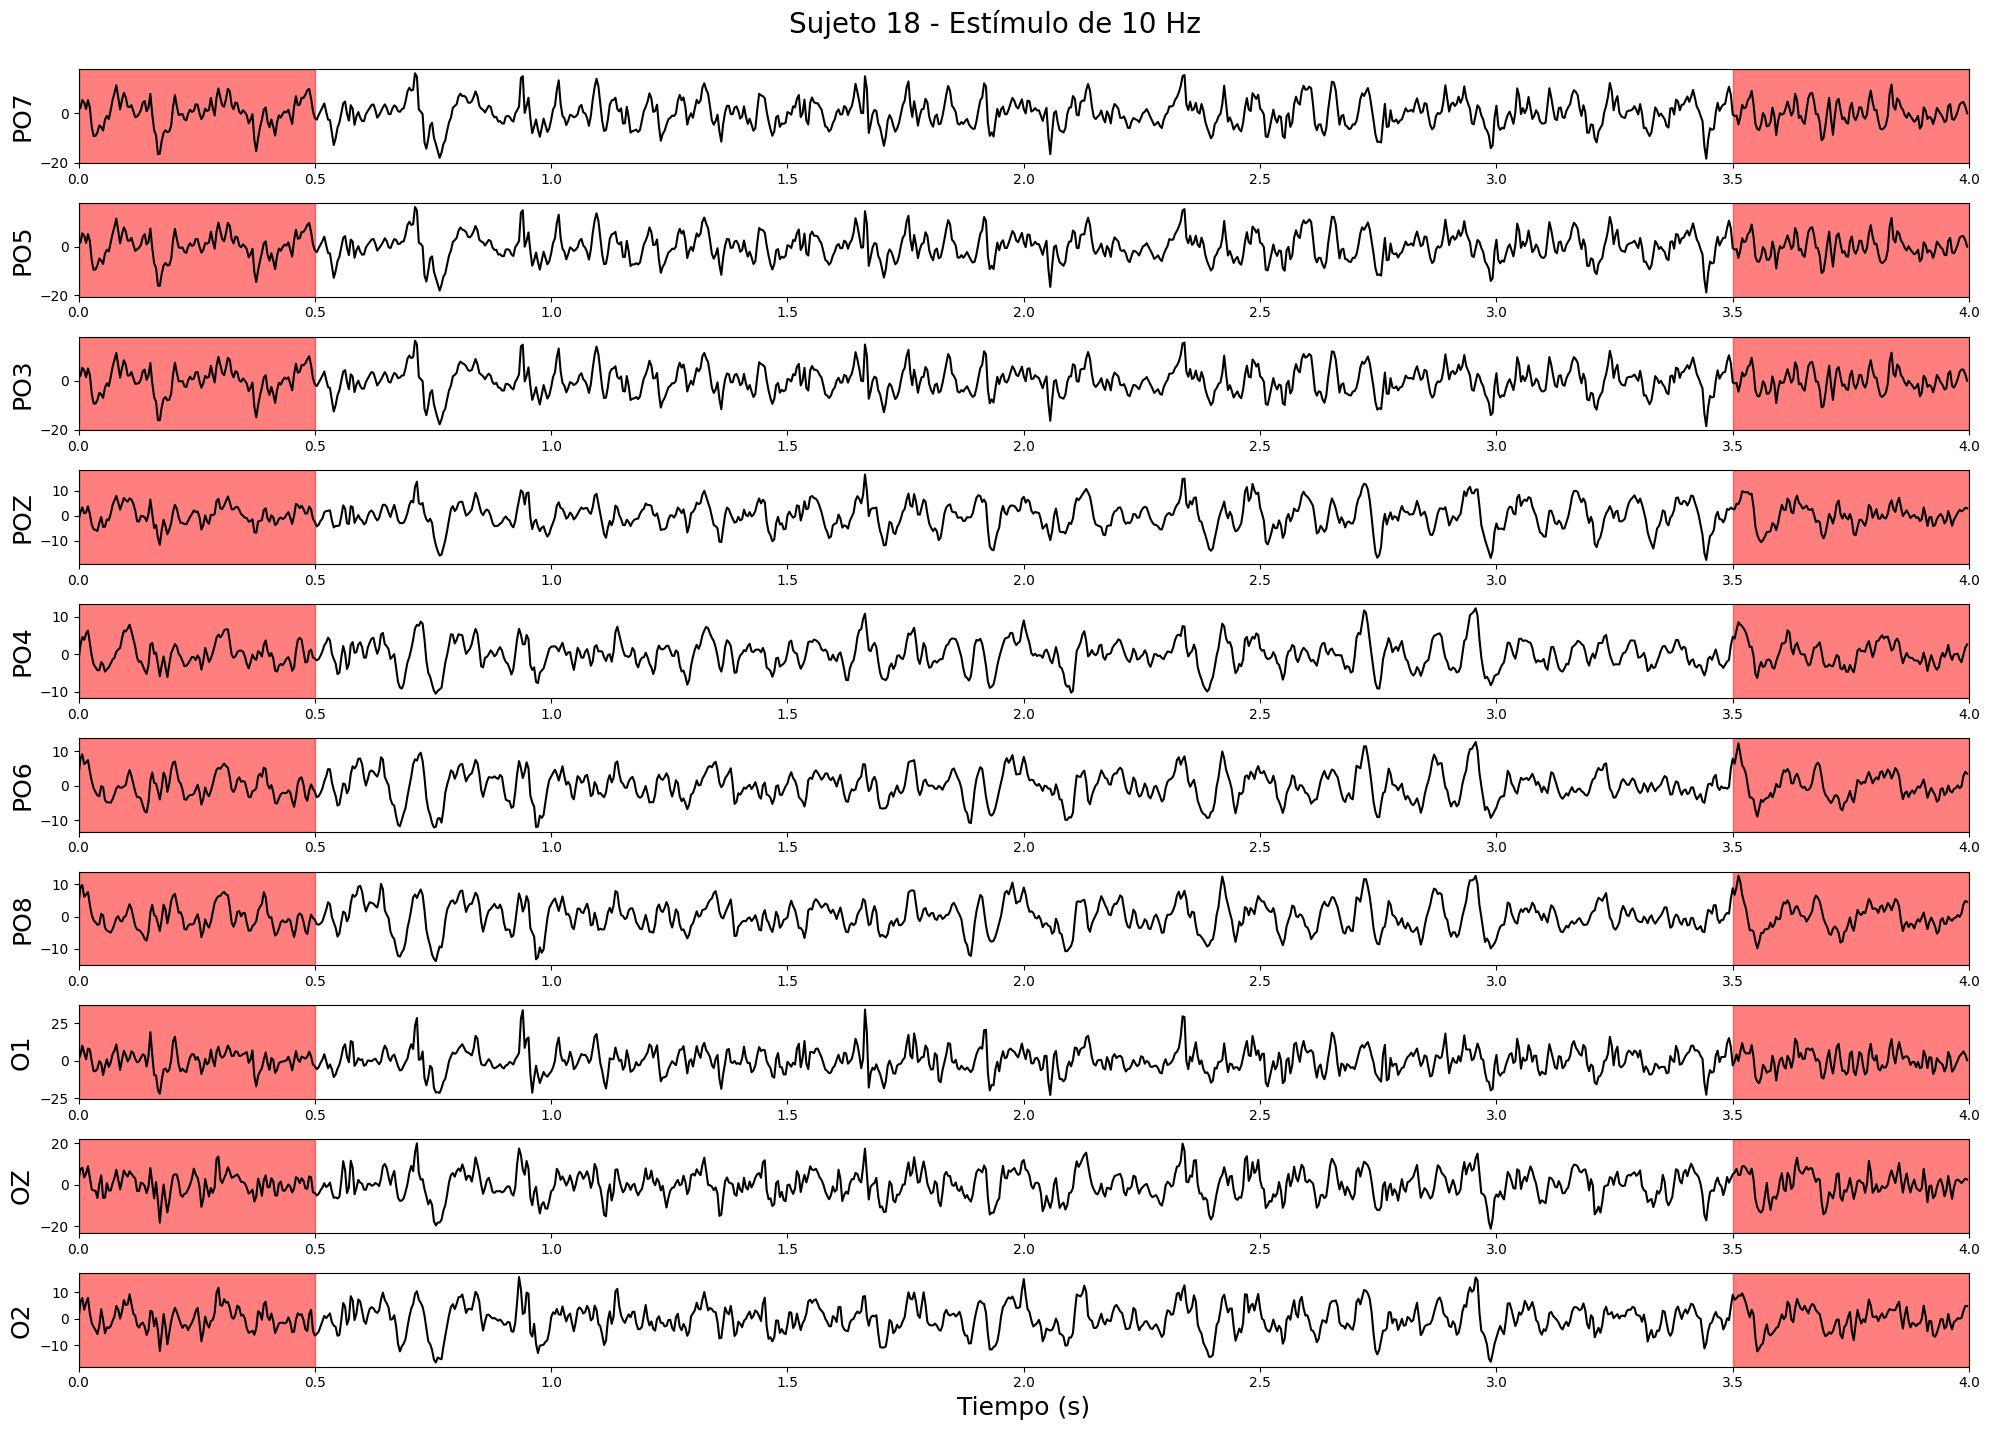

In [25]:
# Visualización multi-canal de la actividad EEG en los electrodos occipitales
figura, ejes_canales = plt.subplots(
    nrows=len(indices_occipitales),
    ncols=1,
    figsize=(20, 1.5 * len(indices_occipitales))
)

# Recorrido por cada canal occipital para representar su señal EEG correspondiente
for i, par in enumerate(electrodos_occipitales):
    eje_actual = ejes_canales[i]
    
    senal = registro_eeg[par[0], :, 0, 0]  # [canal, tiempo, ensayo 0, frecuencia 10 Hz (índice 0)]
    
    # Representación de la señal EEG en negro
    eje_actual.plot(tiempo_completo, senal, color='black')
    
    # Etiqueta del canal (por ejemplo, "Oz", "POz", etc.)
    eje_actual.set_ylabel(par[1], fontsize=18)
    
    # Marcado visual del pre-estímulo
    eje_actual.axvspan(0, 0.5, color='red', alpha=0.5)
    
    # Marcado visual del post-estímulo
    eje_actual.axvspan(3.5, 4.0, color='red', alpha=0.5)
    
    # Ajuste de los límites horizontales
    eje_actual.set_xlim(0, 4)

# Etiqueta común en el eje x (último gráfico)
ejes_canales[-1].set_xlabel("Tiempo (s)", fontsize=18)

# Título global de la figura
figura.suptitle("Sujeto 18 - Estímulo de 10 Hz", fontsize=20)

# Ajuste de espaciado y posición del título
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Mostrar toda la figura
plt.show()


Comparación del pico más alto con y sin filtrado, que muestra cómo, **sin aplicar filtrado**, un **armónico** puede presentar el pico de potencia más alto, mientras que, **al aplicar el filtrado**, el pico más alto corresponde a la **frecuencia fundamental del estímulo**.

Esto evidencia la utilidad del filtrado paso banda para aislar las componentes relevantes del estímulo y evitar que armónicos o ruido interfieran en el análisis espectral.


FILTERED


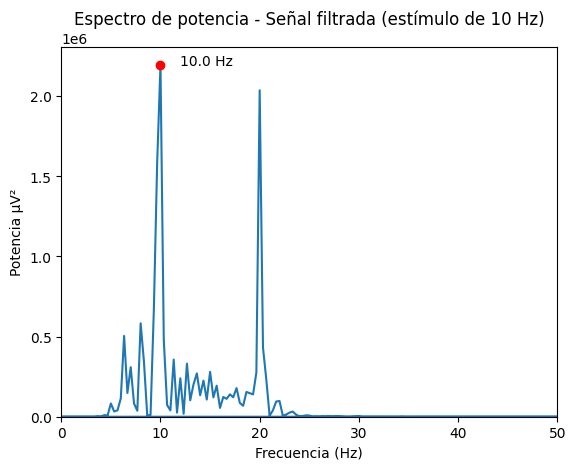

NOT FILTERED


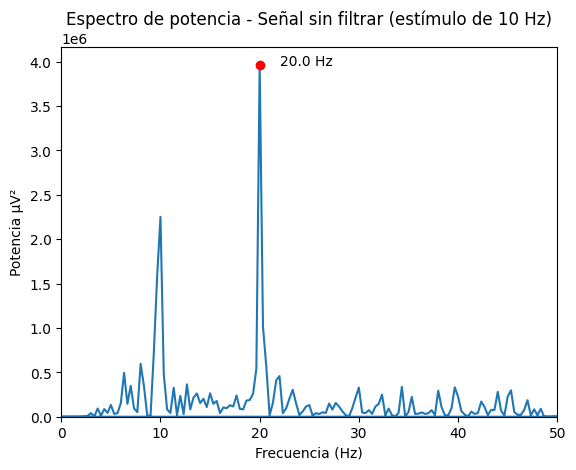

In [26]:
# Carga de datos EEG del sujeto 1 desde la base BETA
# 'datos_eeg' incluye todo el ensayo; 'solo_estimulo' excluye los primeros y últimos 0.5s
# 'duracion_ensayo' es 3 o 4 segundos dependiendo del protocolo
datos_eeg, solo_estimulo, duracion_ensayo = utils.load_ssvep_data("Database Beta", 1)

# Extracción de la señal del canal Oz (índice 61), ensayo 3, frecuencia con índice 7 (10 Hz)
senal_cruda = datos_eeg[61, :, 3, 7]

# Parámetros del filtro paso banda
f_baja = 5
f_alta = 20
fs = 250  # Frecuencia de muestreo (Hz)

# Diseño del filtro Butterworth de 4.º orden entre 5 y 20 Hz
coef_b, coef_a = signal.butter(4, [f_baja, f_alta], fs=fs, btype='band')

# Aplicación del filtro a la señal original
senal_filtrada = signal.lfilter(coef_b, coef_a, senal_cruda)

# ------------------------- ANÁLISIS CON FILTRADO -------------------------

# Transformada de Fourier (FFT) sobre la señal filtrada
fft_filtrada = np.fft.fft(senal_filtrada)

# Vector de frecuencias asociado
frecuencias = np.fft.fftfreq(len(senal_filtrada), d=1/fs)

# Cálculo del espectro de potencia (valor absoluto al cuadrado)
potencia_filtrada = np.abs(fft_filtrada) ** 2

# Identificación del pico máximo de potencia en baja frecuencia
frecuencia_maxima = frecuencias[np.argmax(potencia_filtrada[0:500])]

# Representación gráfica del espectro de potencia filtrado
print("FILTERED")
plt.plot(frecuencias, potencia_filtrada)
plt.xlim(0, 400)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Potencia " + '\u03BC' + 'V²')
plt.title("Espectro de potencia - Señal filtrada (estímulo de 10 Hz)")

# Destacamos el pico de máxima potencia
plt.plot(frecuencias[np.argmax(potencia_filtrada[0:500])], max(potencia_filtrada[0:500]), "o", color="red")
plt.text(frecuencias[np.argmax(potencia_filtrada[0:500])] + 2, max(potencia_filtrada[0:500]), f"{frecuencia_maxima} Hz")

# Enfocamos la zona más relevante del espectro
plt.xlim(0, 50)
plt.ylim(0)
plt.show()

# ------------------------- ANÁLISIS SIN FILTRADO -------------------------

# Repetimos el análisis FFT sobre la señal sin filtrar
fft_cruda = np.fft.fft(senal_cruda)
frecuencias = np.fft.fftfreq(len(senal_cruda), d=1/fs)
potencia_cruda = np.abs(fft_cruda) ** 2

# Localización del pico de potencia
frecuencia_maxima = frecuencias[np.argmax(potencia_cruda[0:500])]

# Visualización del espectro sin filtrado
print("NOT FILTERED")
plt.plot(frecuencias, potencia_cruda)
plt.xlim(0, 400)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Potencia " + '\u03BC' + 'V²')
plt.title("Espectro de potencia - Señal sin filtrar (estímulo de 10 Hz)")

# Señalamos el valor máximo
plt.plot(frecuencias[np.argmax(potencia_cruda[0:500])], max(potencia_cruda[0:500]), "o", color="red")
plt.text(frecuencias[np.argmax(potencia_cruda[0:500])] + 2, max(potencia_cruda[0:500]), f"{frecuencia_maxima} Hz")

# Ajustes para mejorar la visibilidad del espectro bajo 50 Hz
plt.xlim(0, 50)
plt.ylim(0)
plt.show()


**Bandas de frecuencia**


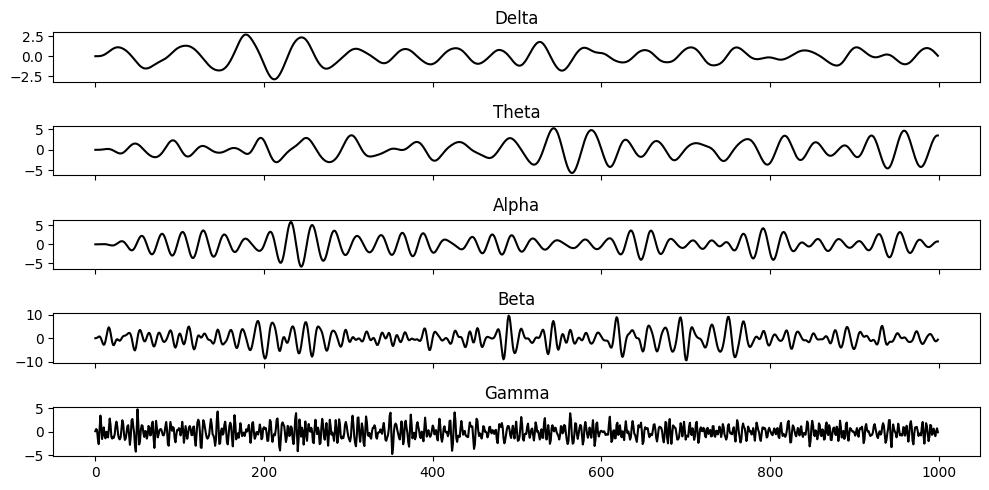

In [24]:
# Cargamos los datos del sujeto 18 desde el conjunto BETA
datos_eeg, estimulo_solo, duracion = utils.load_ssvep_data("Database Beta", 18)

# Frecuencia de muestreo del EEG (Hz)
frecuencia_analisis = 260.0  # Nota: para este análisis se usa 260 Hz (aunque antes usamos 250 Hz)

# Definimos los nombres de las bandas de frecuencia estándar en EEG
nombres_bandas = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Frecuencias iniciales de cada banda
frecuencias_inicio = [0.1, 4.0, 8.0, 12.0, 30.0]

# Frecuencias finales de cada banda
frecuencias_fin = [4.0, 8.0, 12.0, 30.0, 80.0]

# Creamos una figura con 5 subgráficas (una por banda)
figura, ejes_bandas = plt.subplots(nrows=5, figsize=(10, 5), sharex=True)

# Iteramos sobre las bandas de frecuencia para aplicar un filtro paso banda a cada una
for i, eje in enumerate(ejes_bandas):
    # Creamos un filtro de Butterworth de 4.º orden para la banda actual
    coef_b, coef_a = signal.butter(4, [frecuencias_inicio[i], frecuencias_fin[i]], fs=frecuencia_analisis, btype='band')

    # Aplicamos el filtro a la señal del canal 58 (por ejemplo, Oz o POz)
    # Ensayo 0, frecuencia índice 0 (podría corresponder a 10 Hz)
    senal_filtrada = signal.lfilter(coef_b, coef_a, datos_eeg[58, :, 0, 0])

    # Representamos la señal filtrada en escala temporal
    eje.plot(senal_filtrada, color='black')

    # Título de cada subgráfica con el nombre de la banda
    eje.set_title(nombres_bandas[i])

# Ajustamos el diseño para evitar solapamiento entre subgráficas
plt.tight_layout()

# Mostramos la figura final
plt.show()
